# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [259]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [260]:
## Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

#Set seed
seed = 23

#set colormap
sns.set_palette(palette="magma")

## Task 1 (Classifiers and fairness considerations)  
1. Starting from the template, train two different classifiers on the training data: a white-box 
model using logistic regression, and a black-box model using a random forest. Consider 
feature engineering and scaling steps necessary for some of these classifiers and summarize 
the necessary changes in your report. For both models, report on the accuracy of the 
classifier on the test set.

### Preprocessing

In [261]:
#One one column left that is not boolean, AGEP.
#We scale this to between 0-1 because the penalty term is sensitive to scale. I think.
    
column_trans = ColumnTransformer(
    [('scaler', MinMaxScaler(),['AGEP'])], 
    remainder='passthrough')

column_trans.fit(X_train) #Use the training data only to fit the scaler.

X_train.AGEP = column_trans.transform(X_train)[:,0]

X_test.AGEP = column_trans.transform(X_test)[:,0] #Fit both train and test using the fitted scaler.

### Logistic Regression Model: white box

In [262]:
LRclf = LogisticRegression(max_iter=5000, 
                            penalty='l2', 
                            C=0.98497534359086438, 
                            tol=1e-4,
                            solver='saga', 
                            random_state=seed)
LRclf.fit(X_train, y_train)
LR_score = LRclf.score(X_test, y_test)

### Random Forest Model: black box

In [263]:
RFclf = RandomForestClassifier(max_depth=2, 
                                random_state=seed, 
                                n_jobs=-1, 
                                n_estimators=200)
RFclf.fit(X_train, y_train)
RF_score = RFclf.score(X_test, y_test)

In [264]:
print(f'Logistic Reg  score: {LR_score:.2}\nRandom Forest score: {RF_score:.2}')

Logistic Reg  score: 0.77
Random Forest score: 0.75


2. For each classifier, measure statistical parity, equalized odds (both in terms of  T = 0  and  T 
= 1 ), and equality of outcome (both in terms of  S = 0  and  S = 1 ) (Lecture 2). Plot the 
results and discuss the differences that you observe.

### Statistical Parity

$P(S=1|G=2) = P(S=1|G=1)$

### Equalised Odds

$P(S=1|G=2, T=1) = P(S=1|G=1, T=1)$

$P(S=1|G=2, T=0) = P(S=1|G=1, T=0)$

### Equalised Outcomes

$P(T=1|G=2, S=1) = P(T=1|G=1, S=1)$

$P(T=1|G=2, S=0) = P(T=1|G=1, S=0)$

$S$ = Predicted value

$T$ = True value (going to use $A$ instead because ```.T``` is a thing in pandas already)

$G$ = Group status

In [265]:
def stat_parity(model, X_test):
    df = pd.DataFrame(model.predict(X_test), columns=['S'])
    df['G'] = group_test
    df['A'] = y_test

    g1 = sum(df[df.G==1].S)/df[df.G==1].shape[0]
    g2 = sum(df[df.G==2].S)/df[df.G==2].shape[0]

    return g1, g2

def equal_odds(model, X_test, target=1):
    df = pd.DataFrame(model.predict(X_test), columns=['S'])
    df['G'] = group_test
    df['A'] = y_test

    g1 = sum(df[(df.G==1)&(df.A==target)].S)/df[(df.G==1)&(df.A==target)].shape[0]
    g2 = sum(df[(df.G==2)&(df.A==target)].S)/df[(df.G==2)&(df.A==target)].shape[0]

    return g1, g2

def equal_outcomes(model, X_test, s=1):
    df = pd.DataFrame(model.predict(X_test), columns=['S'])
    df['G'] = group_test
    df['A'] = y_test

    g1 = sum(df[(df.G==1)&(df.S==s)].A)/df[(df.G==1)&(df.S==s)].shape[0]
    g2 = sum(df[(df.G==2)&(df.S==s)].A)/df[(df.G==2)&(df.S==s)].shape[0]

    return g1, g2

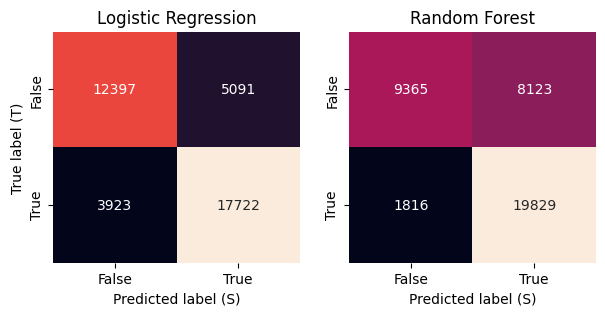

In [266]:
_, ax = plt.subplots(1,2, figsize=(7,3))
cm = confusion_matrix(y_test, LRclf.predict(X_test))
sns.heatmap(cm, annot=True, fmt=".0f", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0], 
            cbar=False)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('Logistic Regression')


cm = confusion_matrix(y_test, RFclf.predict(X_test))
sns.heatmap(cm, annot=True, fmt=".0f", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[1], 
            cbar=False)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('Random Forest');

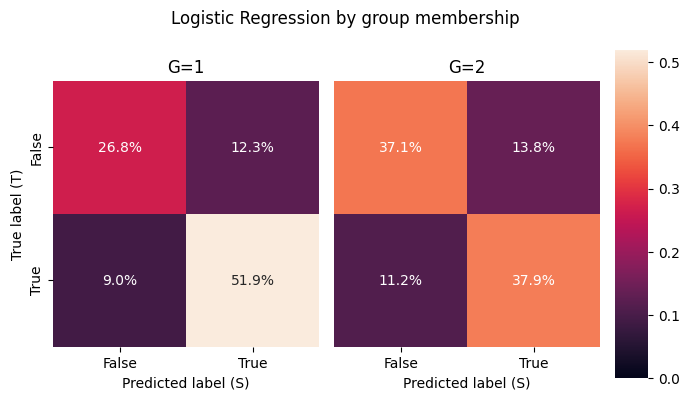

In [267]:
res = pd.DataFrame(LRclf.predict(X_test), columns=['S'])
res['G'] = group_test
res['A'] = y_test

G_1 = res[res.G==1]
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={'width_ratios': [4, 4, 0.5]})
cm = confusion_matrix(G_1.A, G_1.S)
cm = cm/G_1.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0],
            vmin=0, vmax=.52,
            cbar=True,
            cbar_ax=ax[2],
            square=True)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('G=1')

G_2 = res[res.G==2]
cm = confusion_matrix(G_2.A, G_2.S)
cm = cm/G_2.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%",
            xticklabels=['False', 'True'],
            yticklabels=False,
            ax=ax[1],
            vmin=0, vmax=.52,
            cbar=False,
            square=True)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('G=2')
fig.suptitle('Logistic Regression by group membership')
fig.tight_layout();

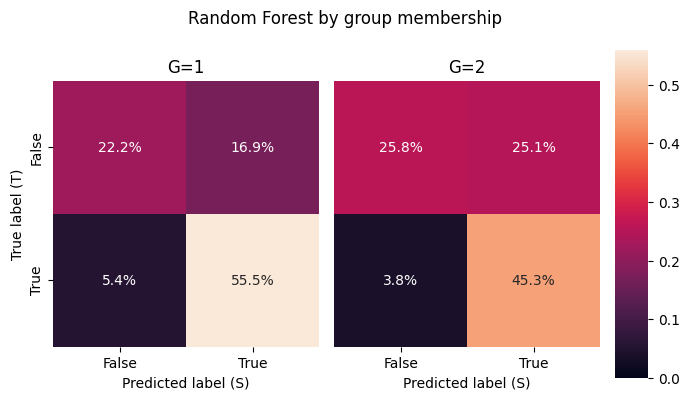

In [268]:
res = pd.DataFrame(RFclf.predict(X_test), columns=['S'])
res['G'] = group_test
res['A'] = y_test

G_1 = res[res.G==1]
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={'width_ratios': [4, 4, 0.5]})
cm = confusion_matrix(G_1.A, G_1.S)
cm = cm/G_1.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%", 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            ax=ax[0],
            vmin=0, vmax=.56,
            cbar=True,
            cbar_ax=ax[2],
            square=True)

ax[0].set_ylabel('True label (T)')
ax[0].set_xlabel('Predicted label (S)')
ax[0].set_title('G=1')

G_2 = res[res.G==2]
cm = confusion_matrix(G_2.A, G_2.S)
cm = cm/G_2.shape[0]
sns.heatmap(cm, annot=True, fmt=".1%",
            xticklabels=['False', 'True'],
            yticklabels=False,
            ax=ax[1],
            vmin=0, vmax=.56,
            cbar=False,
            square=True)

ax[1].set_xlabel('Predicted label (S)')
ax[1].set_title('G=2')
fig.suptitle('Random Forest by group membership')
fig.tight_layout();

In [269]:
g1, g2 = stat_parity(LRclf, X_test)

print(f'Logistic Regression statisical parity check: \ngroup1 {g1:.3}\ngroup2 {g2:.3}')

print()
g1, g2 = stat_parity(RFclf, X_test)

print(f'Random Forest statisical parity check: \ngroup1 {g1:.3}\ngroup2 {g2:.3}')

Logistic Regression statisical parity check: 
group1 0.642
group2 0.517

Random Forest statisical parity check: 
group1 0.723
group2 0.704


In [270]:
## Target == True

g1, g2 = equal_odds(LRclf, X_test)

print(f'Logistic Regression equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_odds(RFclf, X_test)

print(f'Random Forest equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised odds check: 
group1 0.85
group2 0.77

Random Forest equalised odds check: 
group1 0.91
group2 0.92


In [271]:
## Target == False

g1, g2 = equal_odds(LRclf, X_test, target=0)

print(f'Logistic Regression equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_odds(RFclf, X_test, target=0)

print(f'Random Forest equalised odds check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised odds check: 
group1 0.32
group2 0.27

Random Forest equalised odds check: 
group1 0.43
group2 0.49


In [272]:
## Selected == True

g1, g2 = equal_outcomes(LRclf, X_test)

print(f'Logistic Regression equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_outcomes(RFclf, X_test)

print(f'Random Forest equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised outcomes check: 
group1 0.81
group2 0.73

Random Forest equalised outcomes check: 
group1 0.77
group2 0.64


In [273]:
## Selected == False

g1, g2 = equal_outcomes(LRclf, X_test, s=0)

print(f'Logistic Regression equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

print()
g1, g2 = equal_outcomes(RFclf, X_test, s=0)

print(f'Random Forest equalised outcomes check: \ngroup1 {g1:.2}\ngroup2 {g2:.2}')

Logistic Regression equalised outcomes check: 
group1 0.25
group2 0.23

Random Forest equalised outcomes check: 
group1 0.2
group2 0.13


3. Change the classification pipeline to (approximately) fulfill one of the fairness criteria by post-
processing the results. How did the intervention influence the different fairness criteria, how 
did it change the accuracy of the classification?

In [274]:
LRclf.predict_proba(X_test)

array([[0.13811388, 0.86188612],
       [0.10930223, 0.89069777],
       [0.39819798, 0.60180202],
       ...,
       [0.03026655, 0.96973345],
       [0.52210455, 0.47789545],
       [0.45966243, 0.54033757]])

## Task 2 (Explaining white-box models)  
1. Explain the trained logistic regression model. In particular, discuss which features in the 
model are deemed most relevant. Reflect on the interpretation. Does it fit your intuition 
about the prediction task?
2. Pick one data point in the test dataset. Find a counterfactual data point that contrasts the 
outcome of the inference on this data point (e.g., "had X had feature P >=, then it had been 
classified as ..."). Describe how you used the model explanation to find such a counterfactual.


In [ ]:
weights = {}
for i in range(len(LRclf.coef_[0])):
    weights[LRclf.feature_names_in_[i]] = [LRclf.coef_[0][i]]

for k,v in weights.items():
    weights[k].append(np.exp(v)[0])

sorted(weights.items(), key=lambda x: x[1], reverse=True)

In [ ]:
RF_imps = sorted([[round(i,3), j] for i, j in zip(RFclf.feature_importances_, RFclf.feature_names_in_)], reverse=True)

RF_imps

## Task 3 (Model-agnostic explanations)  
1. Both for the white-box and the black-box classifier, use the  shap  module to explain 
predictions. Contrast the two models to each other: What are similarities, how do they differ?
2. For logistic regression, compare the model-agnostic explanation to your analysis in Task 2. 
How do the explanations differ?

## Task 4 (Reflection)  
Given the outcome of your study, which classifier is most suited for the prediction task under 
accuracy, explainability, and fairness considerations?